In [13]:
# !pip install -r ../input/requirements/requirements.txt
# !pip install evaluate

# Imports

In [14]:
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
import torch.nn as nn
import torch

from sentence_transformers import SentenceTransformer, util
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    get_linear_schedule_with_warmup
)
from datasets import Dataset
import evaluate as ev

import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split

from typing import Dict, List, Any, Optional
from dataclasses import dataclass
from datetime import datetime
from tqdm.auto import tqdm
import traceback
import shutil
import optuna
import gc
import re
import os


# Model Implementation

## Losses

In [15]:
class BartWithRegressionCriterion(nn.Module):
    """
    A custom abstract loss function interface that combines the generation loss from a BART model
    with a regression loss for polarity prediction.
    
    This class is designed to be used with a BART model that outputs both
    generated text and regression predictions.
    """

    def forward(self, model_outputs, true_polarities):
        """
        Computes the combined loss.

        Args:
            model_outputs (dict): Contains 'generation_loss' and 'polarities'.
            true_polarities (torch.Tensor): Ground truth polarities.

        Returns:
            torch.Tensor: The computed loss.
        """
        raise NotImplementedError("Subclasses should implement this method.")

class UncertaintyLoss(BartWithRegressionCriterion):
    """
    Implements the Uncertainty-based loss function from Kendall et al. (2018)
    for multi-task learning.

    This loss function learns to balance multiple task losses by weighting them
    based on their homoscedastic uncertainty. It does this by introducing
    trainable parameters (log_vars) for each task.

    The total loss is calculated as:
    L_total = Σ [ (1 / (2*σ_i²)) * L_i + log(σ_i) ]
    where σ_i is the uncertainty for task i, and L_i is its raw loss.

    To maintain numerical stability, we work with log(σ_i²) instead of σ_i.
    Let s_i = log(σ_i²), then σ_i² = exp(s_i). The formula becomes:
    L_total = Σ [ exp(-s_i) * L_i + 0.5 * s_i ]
    
    We have two tasks: 
    - Task 1: Polarity prediction (Regression)
    - Task 2: Explanation generation (Classification-like via Cross-Entropy)
    """
    def __init__(self, regression_loss_fn=nn.SmoothL1Loss()):
        super(UncertaintyLoss, self).__init__()
        # Initialize two trainable log-variance parameters, one for each task.
        # We initialize them to 0.0, which means the initial variance σ² is exp(0) = 1.
        # This gives both tasks equal initial weighting.
        # We name them to make their purpose clear.
        self.log_var_polarity = nn.Parameter(torch.zeros(1))
        self.log_var_explanation = nn.Parameter(torch.zeros(1))
        self.regression_loss_fn = regression_loss_fn  # Loss function for regression task

    def forward(self, model_outputs, true_polarities):
        """
        Calculates the combined, uncertainty-weighted loss.

        Args:
            model_outputs (dict): Contains the model's outputs:
                - 'polarities': Predicted polarities (regression output).
                - 'generation_loss': Pre-computed generation loss (e.g., from BART).
            true_polarities (torch.Tensor): Ground truth polarities for regression.

        Returns:
            torch.Tensor: The final, combined loss to be backpropagated.
        """
        predicted_polarities = model_outputs['polarities']
        loss_explanation = model_outputs['generation_loss']  # BART's pre-computed generation loss

        # Compute the Smooth L1 Loss
        loss_polarities = self.regression_loss_fn(predicted_polarities, true_polarities)

        # Ensure the parameters are on the same device as the input losses
        self.log_var_polarity.data = self.log_var_polarity.data.to(loss_polarities.device)
        self.log_var_explanation.data = self.log_var_explanation.data.to(loss_explanation.device)

        # Calculate the precision terms (1 / (2*σ²))
        # The factor of 0.5 for the regression precision term comes from the
        # Gaussian likelihood derivation in the paper.
        precision_polarity = torch.exp(-self.log_var_polarity)
        
        # The precision term for classification-like losses is (1 / σ²)
        precision_explanation = torch.exp(-self.log_var_explanation)

        # The final loss for each task component
        # Regression term: (1/(2σ²))*L_reg + log(σ) = (1/(2σ²))*L_reg + 0.5*log(σ²)
        term_polarity = 0.5 * precision_polarity * loss_polarities + 0.5 * self.log_var_polarity
        
        # Explanation term: For simplicity and stability, many implementations use the same
        # form for all tasks. This is a robust choice.
        # Here we use the general form: (1/σ²)*L_gen + log(σ) = (1/σ²)*L_gen + 0.5*log(σ²)
        # term_explanation = precision_explanation * loss_explanation + 0.5 * self.log_var_explanation
        
        # A more common and stable reparameterization for all tasks is:
        # L_i_final = exp(-s_i) * L_i + s_i
        # Let's use this for the explanation part for robustness.
        term_explanation = precision_explanation * loss_explanation + self.log_var_explanation

        # The total loss is the sum of the individual task losses
        total_loss = term_polarity + term_explanation

        return {
            'total_loss': total_loss,
            'reg_loss': loss_polarities,
            'gen_loss': loss_explanation
        }

class StaticWeightedLoss(BartWithRegressionCriterion):
    """
    A dedicated class to compute the combined loss for the hybrid model.
    This separates the loss logic from the model's forward pass.
    """
    def __init__(self, regression_loss_fn=nn.MSELoss(), alpha=0.5):
        super().__init__()
        self.alpha = alpha  # Weight for regression loss
        self.regression_loss_fn = regression_loss_fn

    def forward(self, model_outputs, true_polarities):
        # Unpack model outputs
        predicted_polarities = model_outputs['polarities']
        gen_loss = model_outputs['generation_loss']  # BART's pre-computed generation loss

        # Calculate Regression Loss (MSE) for each sample in the batch
        reg_loss = self.regression_loss_fn(predicted_polarities, true_polarities)

        total_loss = (self.alpha * reg_loss) + ((1 - self.alpha) * gen_loss)
        return {
            'total_loss': total_loss,
            'reg_loss': reg_loss,
            'gen_loss': gen_loss
        }

class EuclideanLoss(BartWithRegressionCriterion):
    """
    A dedicated class to compute the combined loss for the hybrid model.
    This separates the loss logic from the model's forward pass.
    """
    def __init__(self, regression_loss_fn=nn.MSELoss()):
        super().__init__()
        self.regression_loss_fn = regression_loss_fn

    def forward(self, model_outputs, true_polarities):
        # Unpack model outputs
        predicted_polarities = model_outputs['polarities']
        gen_loss = model_outputs['generation_loss']  # BART's pre-computed generation loss

        # Calculate Regression Loss (MSE) for each sample in the batch
        reg_loss = self.regression_loss_fn(predicted_polarities, true_polarities)

        # Compute the Euclidean norm of the vector [reg_loss, gen_loss] for each sample
        total_loss = torch.sqrt(reg_loss * reg_loss + gen_loss * gen_loss)
        return {
            'total_loss': total_loss,  # Return the mean loss across the batch
            'reg_loss': reg_loss,
            'gen_loss': gen_loss
        }


## Model Architecture

In [16]:
class BartWithRegression(nn.Module):
    """
    A hybrid model combining BART for explanation generation and a custom
    regression head for polarity prediction.
    """

    DEFAULT_CHECKPOINT = "morenolq/bart-it"
    SEP_TOKEN = "[SEP]"
    USR0_TOKEN = "[USR0]"
    USR1_TOKEN = "[USR1]"

    def __initialize_architecture(self, regression_dropout: float):
        """
        Initializes the architecture of the model, including the BART model
        and the regression head.
        """
        self.regression_head = nn.Sequential(
            nn.Dropout(regression_dropout),
            nn.Linear(self.bart.config.hidden_size, 1),
            nn.Tanh()
        )

    def __init__(
            self,
            load_path: str=None,
            single_sep_token: bool=False,
            init_sep_tokens: str = None,
            regression_dropout: float=0.1,
            verbose: bool=False
    ):
        super().__init__()
        self.single_sep_token = single_sep_token
        self.tokenizer = BartWithRegression.get_tokenizer(single_sep_token)
        if load_path != None and os.path.exists(load_path):
            self.bart = BartForConditionalGeneration.from_pretrained(load_path)
            self.__initialize_architecture(regression_dropout)
            if "regression_head.pt" in os.listdir(load_path):
                self.regression_head.load_state_dict(
                    torch.load(
                        os.path.join(load_path, "regression_head.pt"),
                        map_location=torch.device('cpu')
                    )
                )
            else:
                raise FileNotFoundError(
                    f"'regression_head.pt' not found in {load_path}."
                )
        else:
            self.bart = BartForConditionalGeneration.from_pretrained(self.DEFAULT_CHECKPOINT)
            
            self.bart.resize_token_embeddings(len(self.tokenizer))
            if self.single_sep_token:
                self.bart.config.sep_token_id = self.tokenizer.convert_tokens_to_ids(self.SEP_TOKEN)

                if init_sep_tokens == "mean":
                    sep_id = self.bart.config.sep_token_id
                    sep_open_id = self.tokenizer.convert_tokens_to_ids("<s>")
                    sep_close_id = self.tokenizer.convert_tokens_to_ids("</s>")
                    with torch.no_grad():
                        emb = self.bart.model.shared
                        mean_emb = (emb.weight[sep_open_id] + emb.weight[sep_close_id]) / 2
                        emb.weight[sep_id] = mean_emb
                elif init_sep_tokens == "</s>":
                    sep_id = self.bart.config.sep_token_id
                    sep_open_id = self.tokenizer.convert_tokens_to_ids("</s>")
                    with torch.no_grad():
                        emb = self.bart.model.shared
                        mean_emb = (emb.weight[sep_open_id] + emb.weight[sep_close_id]) / 2
                        emb.weight[sep_id] = mean_emb
            else:
                self.bart.config.sep_token_id = self.tokenizer.convert_tokens_to_ids(self.USR0_TOKEN)
                self.bart.config.sep_token_id2 = self.tokenizer.convert_tokens_to_ids(self.USR1_TOKEN)

            self.__initialize_architecture(regression_dropout)
            if verbose:
                print("[WARNING]: Local model checkpoint not found.")
                print("It will be initialized with default configurations!")

    def __predict_polarities(
            self,
            encoder_last_hidden_state: torch.Tensor,
            sep_token_matrix_mask: torch.Tensor
        ) -> torch.Tensor:
        """
        Predicts the polarities for specific token indices in the encoder's
        last hidden state.
        """
        batch_size = encoder_last_hidden_state.size(0)
        # print(f"encoder_last_hidden_state.shape: {encoder_last_hidden_state.shape}")
        # print(f"sep_token_matrix_mask.shape: {sep_token_matrix_mask.shape}")
        flattened_hidden_states = encoder_last_hidden_state.view(-1, encoder_last_hidden_state.size(-1))
        flattened_sep_mask = sep_token_matrix_mask.view(-1)

        # print(f"flattened_hidden_states.shape: {flattened_hidden_states.shape}")
        # print(f"flattened_sep_mask.shape: {flattened_sep_mask.shape}")

        predicted_polarities = self.regression_head(flattened_hidden_states[flattened_sep_mask]).squeeze(-1)

        return predicted_polarities

    def forward(
        self,
        input_ids,
        attention_mask,
        labels
    ):
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True,
            # output_attentions=False,
        )

        encoder_last_hidden_state = outputs.encoder_last_hidden_state
        sep_token_matrix_mask = (
            input_ids == self.bart.config.sep_token_id
        )
        if not self.single_sep_token:
            sep_token_matrix_mask = sep_token_matrix_mask | (
                (input_ids == self.bart.config.sep_token_id2)
            )
        predicted_polarities = self.__predict_polarities(encoder_last_hidden_state, sep_token_matrix_mask)

        return {
            'polarities': predicted_polarities,
            'explanation_logits': outputs.logits,
            'generation_loss': outputs.loss  # BART's pre-computed generation loss
        }

    def generate(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        **gen_kwargs
    ) -> Dict[str, torch.Tensor]:
        """
        Generates both explanations and polarities from the input data.
        The explanations are generated using the BART model, and the polarities
        are predicted using the regression head.
        """
        # Get encoder outputs
        encoder_outputs = self.bart.model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        encoder_last_hidden_state = encoder_outputs.last_hidden_state

        # Generate explanations using precomputed encoder outputs
        generated_sequences = self.bart.generate(
            input_ids=input_ids, attention_mask=attention_mask,
            encoder_outputs=encoder_outputs,
            **gen_kwargs
        )

        # Find target token index for polarity prediction
        sep_token_matrix_mask = (
            input_ids == self.bart.config.sep_token_id
        )
        if not self.single_sep_token:
            sep_token_matrix_mask = sep_token_matrix_mask | (
                (input_ids == self.bart.config.sep_token_id2)
            )
        predicted_polarities = self.__predict_polarities(encoder_last_hidden_state, sep_token_matrix_mask)

        return {
            'explanations': generated_sequences,
            'polarities': predicted_polarities
        }

    def save_model(self, save_directory: str):
        """
        Saves the fine-tuned BART model, the regression head, and the tokenizer
        to a specified directory.
        """
        os.makedirs(save_directory, exist_ok=True)
        self.bart.save_pretrained(save_directory)
        torch.save(self.regression_head.state_dict(), os.path.join(save_directory, "regression_head.pt"))

    @classmethod
    def get_tokenizer(cls, single_sep_token) -> BartTokenizer:
        tokenizer = BartTokenizer.from_pretrained(cls.DEFAULT_CHECKPOINT)
        if single_sep_token:
            tokenizer.add_special_tokens({
                "additional_special_tokens": [cls.SEP_TOKEN]
            })
        else:
            tokenizer.add_special_tokens({
                "additional_special_tokens": [cls.USR0_TOKEN, cls.USR1_TOKEN]
            })
        return tokenizer


## Data Collator

In [17]:
@dataclass
class MultiTaskBartDataCollator(DataCollatorForSeq2Seq):
    """
    Extends DataCollatorForSeq2Seq to also handle custom 'regression_labels'.
    This class pads the input_ids, attention_mask, and labels as usual,
    but also pads the 'regression_labels' to the maximum length in the batch.
    """
    def __call__(
            self,
            features: List[Dict[str, Any]],
            return_tensors: Optional[str]=None
        ) -> Dict[str, torch.Tensor]:
        # Extract polarities from features and create a 1-D tensor
        # containing all polarities concatenated
        polarities = [polarity for feature in features for polarity in feature.pop('polarities')]

        # Let the parent class handle the standard seq2seq padding and
        # creation of decoder_input_ids.
        # This will correctly pad input_ids, attention_mask, and labels.
        batch = super().__call__(features, return_tensors)
        
        # Convert polarities to a tensor
        batch['polarities'] = torch.tensor(polarities, dtype=torch.float32)
        return batch


## Trainer

In [18]:
class TrainingArguments:
    """
    A simple class to hold training arguments for the hybrid model.
    This is useful for passing around training configurations without
    needing to use a dictionary.
    """
    def __init__(
            self, criterion: BartWithRegressionCriterion,
            num_epochs: int=1, gradient_accumulation_steps: int=1,
            get_scheduler_fn=get_linear_schedule_with_warmup,
            warmup_percentage: float=0.1,
            body_lr: float=3e-5, head_lr: float=1.5e-4,
            weight_decay: float=0.01,
            early_stopping_patience: int=None,
            logging: bool=True, save_path: str=None,
            load_best_model_at_end: bool=False
        ):
        self.num_epochs = num_epochs
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.early_stopping_patience = early_stopping_patience
        self.logging = logging
        self.save_path = save_path
        self.body_lr = body_lr
        self.head_lr = head_lr
        self.warmup_percentage = warmup_percentage
        self.weight_decay = weight_decay
        self.get_scheduler_fn = get_scheduler_fn
        self.criterion = criterion
        self.load_best_model_at_end = load_best_model_at_end

class Trainer:
    """
    A simple trainer class to handle the training loop for the hybrid model.
    It abstracts away the training logic, allowing for easy integration with
    different datasets and models.
    """
    def __init__(
            self, model: BartWithRegression, device,
            args: TrainingArguments=None,
            train_dataloader=None, eval_dataloader=None, test_dataloader=None,
            eval_sts_model='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
        ):
        self.model = model
        self.device = device
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.test_dataloader = test_dataloader
        self.args = args

        if self.args is not None:
            # Define parameter groups for the optimizer
            # A common starting point is a 5x to 10x difference in LR
            bart_params = self.model.bart.parameters()
            regression_head_params = self.model.regression_head.parameters()
            optimizer_grouped_parameters = [
                {"params": bart_params, "lr": self.args.body_lr},
                {"params": regression_head_params, "lr": self.args.head_lr}
            ]

            # Add UncertaintyLoss parameters if applicable
            if isinstance(self.args.criterion, UncertaintyLoss):
                uncertainty_loss_params = self.args.criterion.parameters()
                optimizer_grouped_parameters.append(
                    {"params": uncertainty_loss_params, "lr": self.args.head_lr}  # Use head_lr or a custom LR
                )

            # The AdamW optimizer handles the groups seamlessly
            self.optimizer = AdamW(
                optimizer_grouped_parameters,
                # It discourages the model from developing very large weights
                # forcing it to use all of its weights to a small extent
                # rather than relying heavily on a few
                weight_decay=self.args.weight_decay
            )

            num_training_steps = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_epochs
            # 10 : 100 = num_warmup_steps : num_training_steps
            num_warmup_steps = int(num_training_steps * self.args.warmup_percentage)
            # The learning rate scheduler will also correctly apply its schedule to each group's base LR
            self.lr_scheduler = self.args.get_scheduler_fn(
                self.optimizer, num_warmup_steps=num_warmup_steps,
                num_training_steps=num_training_steps
            )

            # print(f"Number of training steps: {num_training_steps}")
            # print(f"Number of warmup steps: {num_warmup_steps}")

            self.log_history = {
                'epochs': [],
                'total_train_losses': [],
                'reg_train_losses': [],
                'gen_train_losses': [],
                'total_eval_losses': [],
                'reg_eval_losses': [],
                'gen_eval_losses': [],
                'reg_loss_weight': [],
                'gen_loss_weight': []
            }

        # print(f"Loading Evaluation STS model: {eval_sts_model}")
        self.sts_model = SentenceTransformer(eval_sts_model, device=self.device)

    def validate(self):
        """
        Validates the model on the provided dataloader using the specified
        criterion. Returns the average loss over the validation set.
        """
        self.model.eval()
        total_loss = 0.0
        reg_loss = 0.0
        gen_loss = 0.0
        with torch.no_grad():
            eval_progress_bar = tqdm(self.eval_dataloader, desc="Validation")
            for batch in eval_progress_bar:
                true_polarities = batch.pop('polarities').detach().clone().to(self.device)
                for k in batch: batch[k] = batch[k].to(self.device)

                with autocast(device_type=self.device.type):
                    model_outputs = self.model(**batch)
                    loss = self.args.criterion(model_outputs, true_polarities)

                total_loss += loss['total_loss']
                reg_loss += loss['reg_loss']
                gen_loss += loss['gen_loss']

                avg_total_loss = total_loss / len(self.eval_dataloader)
                avg_reg_loss = reg_loss / len(self.eval_dataloader)
                avg_gen_loss = gen_loss / len(self.eval_dataloader)

                eval_progress_bar.set_postfix({
                    'avg_total_loss': avg_total_loss.item(),
                    'avg_reg_loss': avg_reg_loss.item(),
                    'avg_gen_loss': avg_gen_loss.item()
                })
        return {
            'total_loss': avg_total_loss,
            'reg_loss': avg_reg_loss,
            'gen_loss': avg_gen_loss
        }

    def train(
            self,
            trial: optuna.Trial = None
        ):

        if self.args is None:
            raise ValueError("Training arguments must be provided!")
    
        if self.train_dataloader is None:
            raise ValueError("Training dataloader must be provided!")

        if not isinstance(self.args.criterion, BartWithRegressionCriterion):
            raise TypeError("Criterion must be an instance of BartWithRegressionCriterion!")

        # Fundamental if using mixed precision training
        # See pytorch docs: https://docs.pytorch.org/docs/stable/amp.html#gradient-scaling
        scaler = GradScaler()
        best_eval_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.args.num_epochs):
            self.model.train()
            total_train_loss = 0.0
            train_progress_bar = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}")

            for batch_idx, batch in enumerate(train_progress_bar):

                # Pop polarity and explanation labels from batch
                true_polarities = batch.pop('polarities').detach().clone().to(self.device)
                # true_explanation_ids = torch.tensor(batch.pop('labels')).to(device)

                # Move all batch tensors to device
                for k in batch: batch[k] = batch[k].to(self.device)

                # Use autocast for mixed precision training
                with autocast(device_type=self.device.type):
                    # The model forward can now accept the whole batch, as the DataCollator has prepared it perfectly
                    model_outputs = self.model(**batch)
                    
                    # The criterion now only needs the true polarity, as gen_loss is in the model_outputs
                    losses_dict = self.args.criterion(
                        model_outputs=model_outputs,
                        true_polarities=true_polarities
                    )
                    loss = losses_dict['total_loss']

                # Reduce loss to a scalar
                total_train_loss += loss.item()

                # Scale the loss and call backward
                normalized_loss = loss / self.args.gradient_accumulation_steps # Normalize loss
                scaler.scale(normalized_loss).backward()

                if (batch_idx + 1) % self.args.gradient_accumulation_steps == 0:
                    # Unscale gradients and call optimizer.step()
                    scaler.step(self.optimizer)
                    # Update the scale for next iteration
                    scaler.update()
                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step() # Update learning rate
                    self.optimizer.zero_grad()

                # Update progress bar
                train_progress_bar.set_postfix({
                    'avg loss': total_train_loss / (batch_idx + 1),
                    'reg_loss': losses_dict['reg_loss'].item(),
                    'gen_loss': losses_dict['gen_loss'].item(),
                    'lr_body': self.optimizer.param_groups[0]['lr'],
                    'lr_head': self.optimizer.param_groups[1]['lr'],
                    # 'reg_weight': self.args.criterion.log_var_polarity.item(),
                    # 'gen_weight': self.args.criterion.log_var_explanation.item()
                })

            avg_train_loss = total_train_loss / len(self.train_dataloader)

            if self.eval_dataloader is not None:
                eval_losses_dict = self.validate()
                eval_loss = eval_losses_dict['total_loss'].item()
                if eval_loss < best_eval_loss:
                    best_eval_loss = eval_loss
                    patience_counter = 0
                    if self.args.save_path is not None:
                        self.model.save_model(os.path.join(self.args.save_path))
                else:
                    if self.args.early_stopping_patience is not None:
                        patience_counter += 1
                        if patience_counter >= self.args.early_stopping_patience:
                            print(f"Early stopping triggered after {epoch+1} epochs")
                            return

            if self.args.logging:
                self.log_history['epochs'].append(epoch + 1)
                self.log_history['total_train_losses'].append(avg_train_loss)
                self.log_history['reg_train_losses'].append(losses_dict['reg_loss'].item())
                self.log_history['gen_train_losses'].append(losses_dict['gen_loss'].item())
                if isinstance(self.args.criterion, UncertaintyLoss):
                    self.log_history['reg_loss_weight'].append(self.args.criterion.log_var_polarity.item())
                    self.log_history['gen_loss_weight'].append(self.args.criterion.log_var_explanation.item())
                if self.eval_dataloader is not None:
                    self.log_history['total_eval_losses'].append(eval_losses_dict['total_loss'].item())
                    self.log_history['reg_eval_losses'].append(eval_losses_dict['reg_loss'].item())
                    self.log_history['gen_eval_losses'].append(eval_losses_dict['gen_loss'].item())
            
            # --- NEW: Optuna Pruning Integration ---
            if trial is not None:
                # Report the intermediate evaluation loss to Optuna
                trial.report(eval_loss, epoch)
                # Check if the trial should be pruned
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            # --- END NEW ---

        if self.args.load_best_model_at_end and self.args.save_path is not None:
            single_sep_token = self.model.single_sep_token
            dropout_p = self.model.regression_head[0].p
            
            del self.model
            gc.collect()

            self.model = BartWithRegression(
                self.args.save_path,
                single_sep_token=single_sep_token,
                regression_dropout=dropout_p
            ).to(self.device)

    def evaluate(self, leave=True, **gen_kwargs):
        self.model.eval()

        rouge_metric = ev.load('rouge')
        bleu_metric = ev.load('bleu')
        bertscore_metric = ev.load('bertscore')
        all_polarities_pred = []
        all_polarities_true = []
        all_true_explanations = []
        all_predicted_explanations = []
        
        with torch.no_grad():
            for batch in tqdm(self.test_dataloader, desc="Evaluating", leave=leave):
                true_polarities = batch.pop('polarities').detach().clone().to(self.device)
                true_explanation_ids = batch.pop('labels').detach().clone().to(self.device)
                for k in batch: batch[k] = batch[k].to(self.device)

                model_outputs = self.model.generate(**batch, **gen_kwargs)

                all_polarities_pred.extend(model_outputs['polarities'].tolist())
                all_polarities_true.extend(true_polarities)

                predicted_explanations = self.model.tokenizer.batch_decode(
                    model_outputs['explanations'],
                    skip_special_tokens=True
                )
                true_explanation_ids = torch.where(
                    true_explanation_ids == -100,
                    torch.tensor(self.model.tokenizer.pad_token_id)
                        .to(true_explanation_ids.device),
                    true_explanation_ids
                )
                true_explanations = self.model.tokenizer.batch_decode(
                    true_explanation_ids,
                    skip_special_tokens=True
                )
                
                all_true_explanations.extend(true_explanations)
                all_predicted_explanations.extend(predicted_explanations)

                rouge_metric.add_batch(
                    predictions=predicted_explanations,
                    references=true_explanations
                )
                bleu_metric.add_batch(
                    predictions=predicted_explanations,
                    references=[[ref] for ref in true_explanations]
                )

        reference_embeddings = self.sts_model.encode(all_true_explanations, convert_to_tensor=True)
        generated_embeddings = self.sts_model.encode(all_predicted_explanations, convert_to_tensor=True)
        cosine_scores = util.cos_sim(generated_embeddings, reference_embeddings)
        sbert_similarity = torch.diag(cosine_scores).mean().item()

        bertscore_results = bertscore_metric.compute(
            predictions=all_predicted_explanations, 
            references=all_true_explanations, 
            lang="it",
            device=self.device
        )
        bertscore_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])

        rouge_score = rouge_metric.compute()
        bleu_score = bleu_metric.compute()
        mse = F.mse_loss(
            torch.tensor(all_polarities_pred),
            torch.tensor(all_polarities_true)
        ).item()

        return {
            'rouge1': rouge_score['rouge1'],
            'rouge2': rouge_score['rouge2'],
            'rougeL': rouge_score['rougeL'],
            'bleu': bleu_score['bleu'],
            'mse': mse,
            'sbert_similarity': sbert_similarity,
            'bertscore_f1': bertscore_f1
        }

# Utilities

## Hyper-Parameters

In [19]:
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

SINGLE_SEP_TOKEN = False  # Set to True if using a single separator token, False for two separate tokens

losses = {
        "euclidean-mse": EuclideanLoss(
            regression_loss_fn=torch.nn.MSELoss(),
        ).to(DEVICE),
        "euclidean-smoothl1": EuclideanLoss(
            regression_loss_fn=torch.nn.SmoothL1Loss(),
        ).to(DEVICE),
        "uncertainty-mse": UncertaintyLoss(
            regression_loss_fn=torch.nn.MSELoss(),
        ).to(DEVICE),
        "uncertainty-smoothl1": UncertaintyLoss(
            regression_loss_fn=torch.nn.SmoothL1Loss(),
        ).to(DEVICE),
    }

criterion = losses["euclidean-mse"]

# criterion = StaticWeightedLoss(
#     # regression_loss_fn=torch.nn.MSELoss(),
#     regression_loss_fn=torch.nn.SmoothL1Loss(),
#     alpha=0.5
# ).to(DEVICE)

TRAIN_MODE = "train_no_optuna"
# TRAIN_MODE = "train_with_optuna"
TEST_MODE = "test_no_optuna"
# TEST_MODE = "test_with_optuna"

NUM_WORKERS = 4

TEST_SIZE = 0.2
BATCH_SIZE = 1
NUM_EPOCHS = 2
GRADIENT_ACCUMULATION_STEPS = 8
EARLY_STOPPING_PATIENCE = 2
WARMUP_PERCENTAGE = 0.1
WEIGHT_DECAY = 0.01 # int the 0 to 0.1 range
BODY_LR = 3e-5
HEAD_LR = 1.5e-4

OPTUNA_TRAIN_TRIALS=2
OPTUNA_TEST_TRIALS=2
PRUNER_WARMUP_STEPS=2

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


## Paths Utilities

In [20]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# ==== LOCAL SETTINGS ====
PATH = os.path.join(".", "out", "datasets", "cipv-chats-sentiment", "chats") # , "gen2", "chats"
OUT_DIR = os.path.join(".", "out", "models", "Multi-Task BART", timestamp)

# ==== KAGGLE SETTINGS ====
# PATH = os.path.join(os.sep, "kaggle", "input", "cipv-chats-sentiment")
# OUT_DIR = os.path.join(os.sep, "kaggle", "working", "out")


if TRAIN_MODE == "train_with_optuna":
    temp_save_path = OUT_DIR + "-temp"
    save_path = OUT_DIR
    results_path = os.path.join(save_path, "results")
    best_log_history = None
elif TRAIN_MODE == "train_no_optuna":
    suffix = f"-{criterion.__class__.__name__}-{criterion.regression_loss_fn.__class__.__name__}"
    suffix += f"-single_sep_{SINGLE_SEP_TOKEN}"
    save_path = OUT_DIR + suffix
    results_path = os.path.join(save_path, "results")
os.makedirs(save_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

## Kaggle Specific Utilities

In [21]:
# os.listdir(os.path.join(os.sep, "kaggle", "working"))

In [22]:
# zip_file_path = "/kaggle/working/out-EuclideanLoss-MSELoss-single_sep_False"
# shutil.make_archive(zip_file_path, 'zip', zip_file_path)
# shutil.rmtree(zip_file_path)
# os.remove(zip_file_path + '.zip')

## Plots Utilities

In [23]:
def plot_general_learning_curve(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    train_losses = log_history['total_train_losses']
    eval_losses = log_history['total_eval_losses']
    epochs = log_history['epochs']
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train_losses, 'b-o', label='Training Losses')
    plt.plot(epochs, eval_losses, 'r-o', label='Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Learning Curve Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "general_learning_curve.png"))
    plt.show()
    plt.close()

def plot_reg_learning_curve(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    reg_train_losses = log_history['reg_train_losses']
    reg_eval_losses = log_history['reg_eval_losses']
    epochs = log_history['epochs']
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, reg_train_losses, 'g-o', label='Regression Training Losses')
    plt.plot(epochs, reg_eval_losses, 'm-o', label='Regression Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Regression Learning Curve Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "reg_learning_curve.png"))
    plt.show()
    plt.close()

def plot_gen_learning_curve(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    gen_train_losses = log_history['gen_train_losses']
    gen_eval_losses = log_history['gen_eval_losses']
    epochs = log_history['epochs']
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, gen_train_losses, 'c-o', label='Generation Training Losses')
    plt.plot(epochs, gen_eval_losses, 'y-o', label='Generation Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Generation Learning Curve Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "gen_learning_curve.png"))
    plt.show()
    plt.close()

def plot_loss_weights(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    reg_loss_weights = log_history.get('reg_loss_weight', [])
    gen_loss_weights = log_history.get('gen_loss_weight', [])
    epochs = log_history['epochs']
    
    if not reg_loss_weights or not gen_loss_weights:
        print("No loss weights to plot.")
        return
    
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, reg_loss_weights, 'g-o', label='Regression Loss Weight')
    plt.plot(epochs, gen_loss_weights, 'c-o', label='Generation Loss Weight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Weights')
    plt.title('Loss Weights Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "loss_weights.png"))
    plt.show()
    plt.close()

def plot_all_learning_curves(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    epochs = log_history['epochs']
    
    # Plot total train losses
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, log_history['total_train_losses'], 'b-o', label='Total Train Losses')
    plt.plot(epochs, log_history['total_eval_losses'], 'r-o', label='Total Eval Losses')
    plt.plot(epochs, log_history['reg_train_losses'], 'g-o', label='Regression Train Losses')
    plt.plot(epochs, log_history['reg_eval_losses'], 'm-o', label='Regression Eval Losses')
    plt.plot(epochs, log_history['gen_train_losses'], 'c-o', label='Generation Train Losses')
    plt.plot(epochs, log_history['gen_eval_losses'], 'y-o', label='Generation Eval Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Total Train Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "all_learning_curves.png"))
    plt.show()
    plt.close()


# Loading the Dataset

In [24]:
def simple_add(dataset, messages, couple_dir):
    if SINGLE_SEP_TOKEN:
        all_messages = [msg.group("name_content") + "[SEP]" for idx, msg in enumerate(messages)]
    else:
        all_messages = [msg.group("name_content") + f"[USR{idx%2}]" for idx, msg in enumerate(messages)]

    input_chat = "\n".join(all_messages)

    dataset['chats'].append(input_chat)
    dataset['polarities'].append([float(msg.group("polarity")) for msg in messages])
    # use the directory as user_id
    dataset['user_ids'].append(couple_dir)
    dataset['msgs_lengths'].append(len(messages))

def load_dataset(path):
    msgs_regex = re.compile(r"(?P<message>\(?(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)\)? ?\|? ?(?P<name_content>(?P<name>.+):\n?\s?(?P<content>.+))\n?\s?Polarity: (?P<polarity>(?:-?|\+?)\d\.?\d?\d?))")
    explanation_regex = re.compile(r"Spiegazione:\n(?P<explanation>(?:.|\n)+)")
    dataset = {
        "chats": [],
        "explanations": [],
        "polarities": [],
        "user_ids": [],
        "msgs_lengths": []
    }
    skipped = 0
    model_dirs = os.listdir(path)
    for model_dir in tqdm(model_dirs, desc="📂 Loading Dataset"):
        model_dir_path = os.path.join(path, model_dir)
        couple_dirs = os.listdir(model_dir_path)
        for couple_dir in couple_dirs: # tqdm(couple_dirs, desc=f"📂 Loading Directory: {model_dir_path}")
            couple_dir_path = os.path.join(model_dir_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                with open(os.path.join(couple_dir_path, file), "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(msgs_regex.finditer(chat))
                    if len(messages) > 0: # checks if there are matched messages
                        match = explanation_regex.search(chat)
                        if match:
                            dataset['explanations'].append(match.group("explanation"))
                        else:
                            print(f"No explanation found in file: {os.path.join(couple_dir_path, file)}")
                            skipped += 1
                            continue
                        simple_add(dataset, messages, couple_dir)
                    else:
                        skipped += 1
                        print(f"No messages found in file: {os.path.join(couple_dir_path, file)}")
                        
    return dataset, skipped

dataset, skipped = load_dataset(PATH)
dataset = Dataset.from_dict(dataset)
print(f"Skipped: {skipped}")

📂 Loading Dataset:   0%|          | 0/13 [00:00<?, ?it/s]

No explanation found in file: .\out\datasets\cipv-chats-sentiment\chats\gemini-2.5-pro_2025-07-28-08-47-30\2025-07-28-08-48-47\Conclusione o Trasformazione (neutral).txt
Skipped: 1


In [25]:
def print_dataset_info(dataset):
    print(dataset)
    # For each field, print the first entry
    for field in dataset.features:
        print(f"{field}: {dataset[0][field]}\n")

print_dataset_info(dataset)
# print(dataset)

Dataset({
    features: ['chats', 'explanations', 'polarities', 'user_ids', 'msgs_lengths'],
    num_rows: 2065
})
chats: Giulia:
Ciao amore, la maestra di Leo mi ha chiamato. Ha detto che è un po' distratto in classe ultimamente e fa fatica a concentrarsi... Sono un po' preoccupata. Dobbiamo assolutamente parlarne stasera e pensare a come possiamo aiutarlo insieme, come una squadra, ok?[USR0]
Marco:
Mhm, capisco. È una cosa che ha notato solo adesso? Magari vediamo se è solo un periodo passeggero. Comunque sì, stasera ne parliamo con calma per capire meglio la situazione.[USR1]
Giulia:
"Periodo passeggero"? Marco, è da un po' che non lo vedo concentrato nemmeno a casa! Non voglio che queste cose vengano sottovalutate. Non mi sento supportata quando sembri non dare il giusto peso alle mie preoccupazioni su Leo.[USR0]
Marco:
Hai ragione, Giulia. Mi dispiace di aver minimizzato. Non voglio affatto che tu ti senta sola in questo. Capisco che è importante e la tua preoccupazione è la mia p

# Pre-Processing the Dataset

In [26]:
tokenizer = BartWithRegression.get_tokenizer(SINGLE_SEP_TOKEN)

def preprocess(examples):
    tokenized_chats = tokenizer(
        examples['chats'],
        # padding='max_length',
        # truncation=True,
        # max_length=1024,
        # return_tensors='pt',
        text_target=examples['explanations']
    )
    tokenized_chats["polarities"] = examples["polarities"]
    tokenized_chats["user_ids"] = examples["user_ids"]
    tokenized_chats["msgs_lengths"] = examples["msgs_lengths"]
    return tokenized_chats

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    # batch_size=1000,
    remove_columns=dataset.column_names
)
# print_dataset_info(tokenized_dataset)
print(tokenized_dataset)

Map:   0%|          | 0/2065 [00:00<?, ? examples/s]

Dataset({
    features: ['polarities', 'user_ids', 'msgs_lengths', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2065
})


input_ids token length statistics:
Number of samples with more than 1024 tokens: 0
Number of samples with more than 512 tokens: 72

labels token length statistics:
Number of samples with more than 1024 tokens: 363
Number of samples with more than 512 tokens: 2055


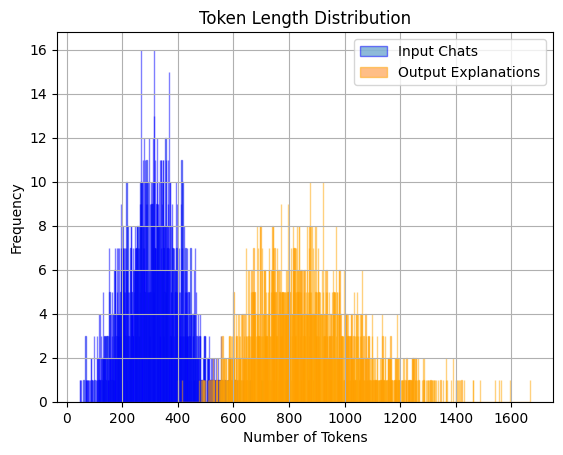

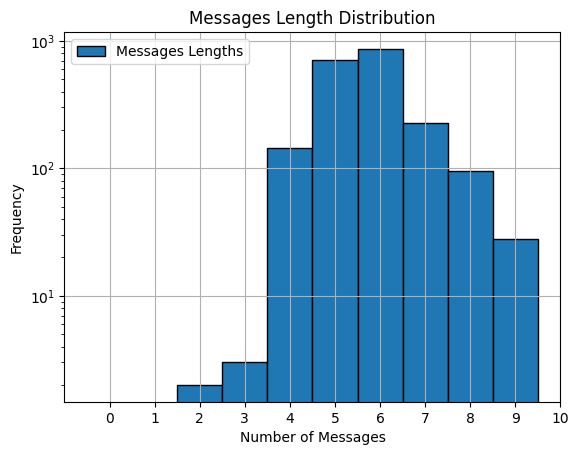

In [27]:
df = DataFrame(tokenized_dataset)

more_than_1024_input_mask = df['input_ids'].apply(lambda x: len(x) > 1024)
more_than_512_input_mask = df['input_ids'].apply(lambda x: len(x) > 512)
more_than_1024_labels_mask = df['labels'].apply(lambda x: len(x) > 1024)
more_than_512_labels_mask = df['labels'].apply(lambda x: len(x) > 512)

# print(f"Tokenized dataset:\n{df.head()}")
print("input_ids token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_input_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_input_mask])}")

print("\nlabels token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_labels_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_labels_mask])}")

# plots histograms for input_ids and labels with different colors in a single plot
# with semi-transparent bars in order to visualize overlaps
# with 1024 + 1 bins where the last bin is for samples with more than 1024 tokens

input_ds_token_lengths = df['input_ids'].apply(lambda x: len(x))
labels_ds_token_lengths = df['labels'].apply(lambda x: len(x))

input_ds_token_lengths.hist(bins=input_ds_token_lengths.max(), edgecolor='blue', alpha=0.5, label='Input Chats')
labels_ds_token_lengths.hist(bins=labels_ds_token_lengths.max(), edgecolor='orange', alpha=0.5, label='Output Explanations')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "token_and_message_length_distribution.png"))
plt.show()

# min_msgs = df['msgs_lengths'].min()
max_msgs = df['msgs_lengths'].max()
df['msgs_lengths'].hist(
    bins=range(max_msgs + 1),  # +2 so last bin includes max
    edgecolor='black',
    label='Messages Lengths',
    align='left'
)
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.title('Messages Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "messages_length_distribution.png"))
plt.yscale('log')
plt.xticks(range(max_msgs + 1))
plt.show()

# Remove all samples with more than 1024 tokens in input_ids and labels
df = df[~more_than_1024_input_mask & ~more_than_1024_labels_mask]

# Splitting the Dataset

In [28]:
print(f"Users in dataset: {df['user_ids'].nunique()}")
print(f"Dataset size: {len(df)}\n")

df.drop(columns=['msgs_lengths'], inplace=True)

# Split the dataset into train, test, and eval sets using user_ids grouped examples
grouped = df.groupby('user_ids')#.size().reset_index(name='counts')
user_ids = list(grouped.groups.keys())[:10]
df = df[df['user_ids'].isin(user_ids)]

train_ids, test_ids = train_test_split(user_ids, test_size=TEST_SIZE, random_state=42)
train_ids, eval_ids = train_test_split(train_ids, test_size=TEST_SIZE, random_state=42)
tokenized_train_set = df[df['user_ids'].isin(train_ids)]
tokenized_test_set = df[df['user_ids'].isin(test_ids)]
tokenized_eval_set = df[df['user_ids'].isin(eval_ids)]

# Prints how many users are in each set
print(f"Users in train set: {tokenized_train_set['user_ids'].nunique()}")
print(f"Users in test set: {tokenized_test_set['user_ids'].nunique()}")
print(f"Users in eval set: {tokenized_eval_set['user_ids'].nunique()}\n")

# Remove the 'user_ids' column from the train, test, and eval sets
tokenized_train_set = tokenized_train_set.drop(columns=['user_ids'])
tokenized_test_set = tokenized_test_set.drop(columns=['user_ids'])
tokenized_eval_set = tokenized_eval_set.drop(columns=['user_ids'])

tokenized_train_set = tokenized_train_set.reset_index(drop=True)
tokenized_test_set = tokenized_test_set.reset_index(drop=True)
tokenized_eval_set = tokenized_eval_set.reset_index(drop=True)

tokenized_train_set = Dataset.from_pandas(tokenized_train_set)
tokenized_test_set = Dataset.from_pandas(tokenized_test_set)
tokenized_eval_set = Dataset.from_pandas(tokenized_eval_set)

print(f"Train set size: {len(tokenized_train_set)}")
print(f"Test set size: {len(tokenized_test_set)}")
print(f"Eval set size: {len(tokenized_eval_set)}\n")

# Set the format to PyTorch tensors
tokenized_train_set.set_format("torch")
tokenized_test_set.set_format("torch")
tokenized_eval_set.set_format("torch")

print_dataset_info(tokenized_train_set)

Users in dataset: 103
Dataset size: 1702

Users in train set: 6
Users in test set: 2
Users in eval set: 2

Train set size: 110
Test set size: 40
Eval set size: 37

Dataset({
    features: ['polarities', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 110
})
polarities: tensor([ 0.1000, -0.2000, -0.8000,  0.9000,  0.8000,  0.9000,  1.0000])

input_ids: tensor([    0, 19953, 26809,    30,   203,    41,   428, 13128,    16,   710,
         8903,   312,  4266,   406,  2440,  1913,  3307,   225,    77,    82,
        13415,    35,  2628,  7479,  3389,   322,    77,   329, 29022, 11355,
           16,  6577,   676,  1777,  8095,  2100,    18, 18770,   312,   465,
         1337, 25264, 17059,    18, 52000,   203,    41,   428, 13128, 12963,
           30,   203, 19953,    16,   384,  6324,  2024,  9689,  2100,    18,
         4266,   345, 11264,    16,  4560,   722,  2237,   322,    77,   329,
         7672,  4523,    18, 18411,   329,    11,  5124, 30015,    16,   332,
          329,

# Preparing Dataloaders

In [29]:
data_collator = MultiTaskBartDataCollator(tokenizer=tokenizer)

train_dataloader = DataLoader(
    tokenized_train_set,
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=data_collator,
    # Parallelize data loading so the GPU
    # doesn't have to wait for the CPU
    # to prepare the next batch.
    num_workers=NUM_WORKERS
)
test_dataloader = DataLoader(
    tokenized_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=NUM_WORKERS
)
eval_dataloader = DataLoader(
    tokenized_eval_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=NUM_WORKERS
)

# Training the Model

In [30]:
trainer = None

## Training without Hyperparameter Tuning

In [ ]:
if TRAIN_MODE == "train_no_optuna":

    model = BartWithRegression(
        single_sep_token=SINGLE_SEP_TOKEN
    ).to(DEVICE)
    # model = torch.compile(model)

    args = TrainingArguments(
        criterion=criterion,
        num_epochs=NUM_EPOCHS,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        # get_scheduler_fn=get_linear_schedule_with_warmup,
        warmup_percentage=WARMUP_PERCENTAGE,
        body_lr=BODY_LR, head_lr=HEAD_LR,
        weight_decay=WEIGHT_DECAY,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        logging=True,
        save_path=save_path,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model, args=args, device=DEVICE,
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        test_dataloader=test_dataloader
    )
    trainer.train()

    plot_general_learning_curve(
        trainer.log_history,
        results_path
    )
    plot_reg_learning_curve(
        trainer.log_history,
        results_path
    )
    plot_gen_learning_curve(
        trainer.log_history,
        results_path
    )

    plot_loss_weights(
        trainer.log_history,
        results_path
    )

    # del model, trainer
    # gc.collect()
    # torch.cuda.empty_cache()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


## Train with Optuna Hyperparameters Tuning

In [ ]:
# --- Define the Objective Function for Optuna ---
def objective(trial: optuna.Trial):
    """
    An objective function to be maximized or minimized by Optuna.
    This function takes a `trial` object, sets up a model with hyperparameters suggested
    by the trial, trains it, and returns the performance metric to optimize (eval_loss).
    """

    # BODY_LR = 3e-5
    # HEAD_LR = 1.5e-4
    criterion = trial.suggest_categorical("criterion", list(losses.keys()))
    head_lr = trial.suggest_float("head_lr", 1e-5, 1e-3, log=True)
    body_lr = trial.suggest_float("body_lr", 1e-5, 1e-4, log=True)
    # batch_size = trial.suggest_categorical("batch_size", [4, 8])
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.1, log=True)
    # label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    
    # print(f"Trial {trial.number} - Hyperparameters:")
    # print(f"  Criterion: {criterion}")
    # print(f"  Head LR: {head_lr:.6f}")
    # print(f"  Body LR: {body_lr:.6f}")
    # print(f"  Weight Decay: {weight_decay:.6f}")

    criterion = losses[criterion]

    try:
        model = BartWithRegression().to(DEVICE)
        # model = torch.compile(model)

        args = TrainingArguments(
            criterion=criterion,
            num_epochs=NUM_EPOCHS,
            gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
            # get_scheduler_fn=get_linear_schedule_with_warmup,
            warmup_percentage=WARMUP_PERCENTAGE,
            body_lr=body_lr, head_lr=head_lr,
            weight_decay=weight_decay,
            early_stopping_patience=None,
            logging=True,
            save_path=temp_save_path,
            load_best_model_at_end=True
        )

        current_trainer = Trainer(
            model=model, args=args, device=DEVICE,
            train_dataloader=train_dataloader,
            eval_dataloader=eval_dataloader
        )
        current_trainer.train()

        best_eval_loss = min(current_trainer.log_history['total_eval_losses'])

        # Check if this is the best trial so far
        if trial.number == 0 or best_eval_loss > trial.study.best_value:
            shutil.rmtree(save_path)
            os.rename(temp_save_path, save_path)
            plot_general_learning_curve(
                current_trainer.log_history,
                results_path
            )
            plot_reg_learning_curve(
                current_trainer.log_history,
                results_path
            )
            plot_gen_learning_curve(
                current_trainer.log_history,
                results_path
            )
            plot_loss_weights(
                trainer.log_history,
                results_path
            )
            trainer = current_trainer
            # print(f"New best model saved with score: {best_eval_loss:.4f}")
        
        # --- Clean up GPU memory before the next trial ---
        del model, current_trainer, args
        gc.collect()
        torch.cuda.empty_cache()

        # Return the best validation loss achieved during this trial
        return best_eval_loss

    except optuna.exceptions.TrialPruned as e:
        # --- Handle pruned trials ---
        # Clean up memory for pruned trials as well
        gc.collect()
        torch.cuda.empty_cache()
        raise e
    except Exception as e:
        # --- Handle other errors like CUDA OOM ---
        print("Trial failed with error:")
        traceback.print_exc()
        gc.collect()
        torch.cuda.empty_cache()
        # Return a very high loss value so Optuna knows this trial was bad
        return float('inf')

In [ ]:
if TRAIN_MODE == "train_with_optuna":
    # Create a study object. `direction="minimize"` means Optuna will try to minimize the return value of `objective`.
    # The TPE sampler is the algorithm for Bayesian Optimization.
    # The MedianPruner is an aggressive early stopping algorithm.
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=PRUNER_WARMUP_STEPS) # Prune after the 1st epoch
    )

    study.optimize(
        objective,
        n_trials=OPTUNA_TRAIN_TRIALS,
        show_progress_bar=True
    )

    print("Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")

    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value (min eval loss): {best_trial.value}")

    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    df = study.trials_dataframe()
    path = os.path.join(results_path, "optuna_train_hyperparams_results.csv")
    df.to_csv(path)
    print(f"\nStudy results saved to {path}")

# Testing the Model

## Loading the Model

In [ ]:
# loaded_model = BartWithRegression(
#     ".\\out\\models\\Multi-Task BART\\Euclidea_2Sep_20_epoche",
#     single_sep_token=SINGLE_SEP_TOKEN,
#     verbose=True
# ).to(DEVICE)
# trainer = Trainer(
#     model=loaded_model, args=None, device=DEVICE,
#     train_dataloader=None,
#     eval_dataloader=eval_dataloader,
#     test_dataloader=test_dataloader
# )

## Generation Hyperparameters Tuning with Optuna

In [ ]:
def objective_generation(trial: optuna.Trial):
    decoding_strategy = trial.suggest_categorical("strategy", ["beam_search", "sampling"])

    gen_kwargs = {
        "max_length": 1024,
        "repetition_penalty": trial.suggest_float("repetition_penalty", 1.0, 1.3)
    }

    if decoding_strategy == "beam_search":
        gen_kwargs["num_beams"] = trial.suggest_int("num_beams", 2, 8)
        gen_kwargs["early_stopping"] = True # Usually a good idea with beam search
    
    elif decoding_strategy == "sampling":
        gen_kwargs["do_sample"] = True
        gen_kwargs["top_p"] = trial.suggest_float("top_p", 0.85, 0.98)
        gen_kwargs["top_k"] = trial.suggest_int("top_k", 20, 100) # Optional, often top_p is enough
        gen_kwargs["temperature"] = trial.suggest_float("temperature", 0.7, 1.0)

    print(f"--- Trial {trial.number}: Testing with {gen_kwargs} ---")

    # This is fast because it's only inference
    results = trainer.evaluate(eval_dataloader, leave=False, **gen_kwargs)

    # We want to maximize a semantic score. Let's choose BERTScore F1.
    metric_to_optimize = 'sbert_similarity'
    score = results[metric_to_optimize]
    print(f"Trial {trial.number} Result -> {metric_to_optimize}: {score:.4f}")
    
    # Clean up memory just in case, although less critical for inference
    gc.collect()
    torch.cuda.empty_cache()

    return metric_to_optimize

In [ ]:
if TEST_MODE == "test_with_optuna":
    # For this search, we want to MAXIMIZE the score.
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        # Pruning is not needed here because each trial is just one full evaluation,
        # there are no intermediate steps to prune.
    )

    # Run the optimization. 20-30 trials should be plenty for this.
    study.optimize(
        objective_generation,
        n_trials=OPTUNA_TEST_TRIALS,
        show_progress_bar=True,
        # n_jobs=-1
    )

    print("\n\n--- Generation Hyperparameter Search Complete ---")
    print(f"  Number of finished trials: {len(study.trials)}")

    print("Best trial for generation:")
    best_trial = study.best_trial
    print(f"    Best Score: {best_trial.value:.4f}")

    print("  Best Generation Params: ")
    best_hyperparams = best_trial.params
    for key, value in best_hyperparams.items():
        print(f"    {key}: {value}")

    df = study.trials_dataframe()
    path = os.path.join(results_path, "optuna_gen_hyperparams_results.csv")
    df.to_csv(path)
    print(f"\nGeneration study results saved to {path}")

## Default Generation Hyperparameters

In [ ]:
if TEST_MODE == "test_no_optuna":
    best_hyperparams = {
        # "num_beams": 1,
        # "repetition_penalty": 1.2,
        # "early_stopping": True,
        "do_sample": True,
        "top_p": 0.95,
        # Top-k sampling is a simple generalization of greedy decoding. Instead of choosing
        # the single most probable word to generate, we first truncate the distribution to the
        # top k most likely words, renormalize to produce a legitimate probability distribution,
        # and then randomly sample from within these k words according to their renormalized
        # probabilities.
        "top_k": 20,
        "temperature": 0.6 # 0.6
    }
    print(f"Using default hyperparameters: {best_hyperparams}")

## Inference Example

In [ ]:
# def inference(model, input_text):
#     """
#     Run inference on a single input text and print the results.
#     """
#     tokenized = tokenizer(
#         input_text, 
#         return_tensors='pt', 
#         truncation=True, 
#         max_length=1024
#     ).to(DEVICE)
#     # input_len = tokenized['input_ids'].shape[1]
#     # max_length = min(int(input_len * 3.95), 1024)  # 20% longer than input, capped at 1024
#     max_length = 1024  # Use a fixed max length for generation

#     output = model.generate(
#         input_ids=tokenized['input_ids'][0].unsqueeze(0),
#         attention_mask=tokenized['attention_mask'][0].unsqueeze(0),
#         max_length=max_length,
#         **best_hyperparams
#     )

#     decoded_output = tokenizer.decode(
#         output['explanations'][0], 
#         skip_special_tokens=True
#     )

#     return {
#         "polarities": output['polarities'],
#         "explanations": decoded_output
#     }


# print(best_hyperparams)
# chat = '''
# Topolina:
# Ciao[USR0]
# '''
# output = inference(trainer.model, chat)
# print(f"Output Polarities: {output['polarities']}")
# print(f"Output Explanations: {output['explanations']}")

In [ ]:
for example in tokenized_train_set.select(range(1)):
    decoded_chat = tokenizer.decode(example['input_ids']) # , skip_special_tokens=True
    decoded_true_explanation = tokenizer.decode(example['labels'], skip_special_tokens=True)

    output = inference(trainer.model, decoded_chat)

    print(f"Message:\n{decoded_chat}")
    print(f"True Polarity:{example['polarities']}")
    print(f"True Explanation:\n{decoded_true_explanation}\n")
    print(f"Generated Polarity:{output['polarities']}")
    print(f"Generated Explanation:\n{output['explanations']}\n")
    print("\n\n")

## Evaluation of the Trained Model

In [ ]:
results = trainer.evaluate(**best_hyperparams)
with open(os.path.join(results_path, "test_results.txt"), "w") as f:
    for key, value in results.items():
        print(f"{key}: {value:.4f}")
        f.write(f"{key}: {value:.4f}\n")